In [1]:
import pandas as pd
import numpy as np
import datetime
from pathlib import Path
from alpha_vantage.timeseries import TimeSeries
import sys
import os


## For Collections, Manipulation and Visualization of Data
import numpy as np
import pandas as pd
import pandas_datareader as web
from pandas_datareader.data import DataReader
import matplotlib

import backtrader as bt

In [2]:
ts = TimeSeries(key='API_KEY', output_format='pandas')
data, metadata = ts.get_daily_adjusted(symbol='NVDA', outputsize='full')
print(data.head(5))

            1. open  2. high   3. low  4. close  5. adjusted close  \
date                                                                 
2021-03-15   514.59   528.27  510.685    527.65             527.65   
2021-03-12   505.93   515.55  503.600    514.24             514.24   
2021-03-11   518.00   521.85  509.380    519.74             519.74   
2021-03-10   513.62   519.20  498.300    498.73             498.73   
2021-03-09   485.21   504.67  482.370    500.81             500.81   

             6. volume  7. dividend amount  8. split coefficient  
date                                                              
2021-03-15   5563011.0                0.00                   1.0  
2021-03-12   6099099.0                0.00                   1.0  
2021-03-11   7497857.0                0.00                   1.0  
2021-03-10   9609414.0                0.00                   1.0  
2021-03-09  13045638.0                0.16                   1.0  


In [3]:
NVDA = web.get_data_yahoo("NVDA",
                            start = "2020-01-01",
                            end = "2020-10-31")

In [4]:
NVDA

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2019-12-31,235.679993,230.130005,230.899994,235.300003,5775100.0,234.912384
2020-01-02,239.910004,236.720001,238.750000,239.910004,5938400.0,239.514771
2020-01-03,237.830002,234.100006,235.100006,236.070007,5134600.0,235.681122
2020-01-06,237.270004,231.270004,232.320007,237.059998,6565900.0,236.669479
2020-01-07,241.770004,236.389999,238.199997,239.929993,7871400.0,239.534729
...,...,...,...,...,...,...
2020-10-26,547.710022,521.539978,537.080017,525.650024,8422400.0,525.494751
2020-10-27,537.679993,527.659973,532.239990,535.869995,6263000.0,535.711731
2020-10-28,530.400024,504.359985,527.919983,505.079987,9413000.0,504.930817


In [5]:
import backtrader as bt
class CrossoverStrategy(bt.Strategy):
    # list of parameters which are configurable for the strategy
    params = dict(fast_period=12, slow_period=26, signal_period=9)

    def __init__(self):

        self.fast_ma = bt.indicators.EMA(self.data.close, period=self.p.fast_period)
        self.slow_ma = bt.indicators.EMA(self.data.close, period=self.p.slow_period)
        self.macd_line = self.fast_ma - self.slow_ma
        self.signal_line = bt.indicators.EMA(self.macd_line, period=self.p.signal_period)
        self.macd_crossover = bt.indicators.CrossOver(self.macd_line, self.signal_line)

    def next(self):

        if self.macd_crossover > 0:
            self.buy()  # enter long position
        elif self.macd_crossover < 0:
            self.close()  # close long position

In [6]:
TICKER = "NVDA"
STRATEGY_PARAMS = dict(fast_period=12, slow_period=26, signal_period=9)


def run_backtest(plot=True, **strategy_params):

    cerebro = bt.Cerebro()
    cerebro.adddata(
        bt.feeds.PandasData(dataname=web.get_data_yahoo("NVDA",
                            start = "2020-01-01",
                            end = "2020-10-31"), name=TICKER)
    )

    # Remember to set it high enough or the strategy may not
    # be able to trade because of short of cash
    cerebro.broker.setcash(100000.0)

    # Print out the starting conditions
    print(f"Starting Portfolio Value: {cerebro.broker.getvalue():,.2f}")

    # Although we have defined some default params in the strategy,
    # we can override it by passing in keyword arguments here.
    cerebro.addstrategy(CrossoverStrategy, **strategy_params)

    cerebro.addobserver(bt.observers.Trades)
    cerebro.addobserver(bt.observers.DrawDown)
    cerebro.addanalyzer(bt.analyzers.SharpeRatio)

    # Let's say that we have 0.25% slippage and commission per trade,
    # that is 0.5% in total for a round trip.
    cerebro.broker.setcommission(commission=0.05, margin=False)

    # Run over everything
    strats = cerebro.run()

    print(f"Final Portfolio Value:    {cerebro.broker.getvalue():,.2f}")

    if plot:
        cerebro.plot()

Starting Portfolio Value: 100,000.00
Final Portfolio Value:    99,847.38


<IPython.core.display.Javascript object>


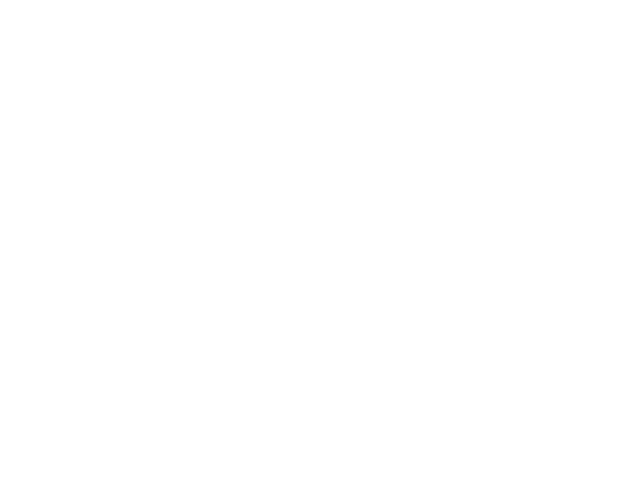

In [7]:
run_backtest(plot=True, **STRATEGY_PARAMS)

In [8]:
#import matplotlib.pyplot as plt
import numpy as np
#import seaborn as sns
from tqdm import trange
import time
import random
from deap import base
from deap import creator
from deap import tools


# fix the seed so that we will get the same results
# feel free to change it or comment out the line
random.seed(1)

# GA parameters
PARAM_NAMES = ["fast_period", "slow_period", "signal_period"]

# End Conditions: 20 iterations
NGEN = 20

# Initial Population: 100 individuals
NPOP = 100

# Crosover Strategy: Uniform crossover with 50% chance for each gene to crossover
CXPB = 0.5

# Mutation Probability: 30% for each gene
MUTPB = 0.3

data = bt.feeds.PandasData(dataname=web.get_data_yahoo("NVDA",
                            start = "2020-01-01",
                            end = "2020-10-31"), name=TICKER)


def evaluate(individual, plot=False, log=False):

    # convert list of parameter values into dictionary of kwargs
    strategy_params = {k: v for k, v in zip(PARAM_NAMES, individual)}

    # fast moving average by definition cannot be slower than the slow one
    if strategy_params["fast_period"] >= strategy_params["slow_period"]:
        return [-np.inf]

    # by setting stdstats to False, backtrader will not store the changes in
    # statistics like number of trades, buys & sells, etc.
    cerebro = bt.Cerebro(stdstats=False)
    cerebro.adddata(data)

    # Remember to set it high enough or the strategy may not
    # be able to trade because of short of cash
    initial_capital = 100_000.0
    cerebro.broker.setcash(initial_capital)

    # Pass in the genes of the individual as kwargs
    cerebro.addstrategy(CrossoverStrategy, **strategy_params)

    # This is needed for calculating our fitness score
    cerebro.addanalyzer(bt.analyzers.DrawDown)

    # Let's say that we have 0.25% slippage and commission per trade,
    # that is 0.5% in total for a round trip.
    cerebro.broker.setcommission(commission=0.05, margin=False)

    # Run over everything
    strats = cerebro.run()

    profit = cerebro.broker.getvalue() - initial_capital
    max_dd = strats[0].analyzers.drawdown.get_analysis()["max"]["moneydown"]
    fitness = profit / (max_dd if max_dd > 0 else 1)

    if log:
        print(f"Starting Portfolio Value: {initial_capital:,.2f}")
        print(f"Final Portfolio Value:    {cerebro.broker.getvalue():,.2f}")
        print(f"Total Profit:             {profit:,.2f}")
        print(f"Maximum Drawdown:         {max_dd:,.2f}")
        print(f"Profit / Max DD:          {fitness}")

    if plot:
        cerebro.plot()

    return [fitness]


# our fitness score is supposed to be maximised and there is only 1 objective
creator.create("FitnessMax", base.Fitness, weights=(1.0,))

# our individual is a list of genes, with the fitness score the higher the better
creator.create("Individual", list, fitness=creator.FitnessMax)

# register some handy functions for calling
toolbox = base.Toolbox()
toolbox.register("indices", random.sample, range(NPOP), NPOP)
# crossover strategy
toolbox.register("mate", tools.cxUniform, indpb=CXPB)
# mutation strategy
toolbox.register("mutate", tools.mutUniformInt, low=1, up=151, indpb=0.2)
# selection strategy
toolbox.register("select", tools.selTournament, tournsize=3)
# fitness function
toolbox.register("evaluate", evaluate)

# definition of an individual & a population
toolbox.register("attr_fast_period", random.randint, 1, 51)
toolbox.register("attr_slow_period", random.randint, 10, 151)
toolbox.register("attr_signal_period", random.randint, 1, 101)
toolbox.register(
    "individual",
    tools.initCycle,
    creator.Individual,
    (
        toolbox.attr_fast_period,
        toolbox.attr_slow_period,
        toolbox.attr_signal_period,
    ),
)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

mean = np.ndarray(NGEN)
best = np.ndarray(NGEN)
hall_of_fame = tools.HallOfFame(maxsize=3)

t = time.perf_counter()
pop = toolbox.population(n=NPOP)
for g in trange(NGEN):
    # Select the next generation individuals
    offspring = toolbox.select(pop, len(pop))
    # Clone the selected individuals
    offspring = list(map(toolbox.clone, offspring))

    # Apply crossover on the offspring
    for child1, child2 in zip(offspring[::2], offspring[1::2]):
        if random.random() < CXPB:
            toolbox.mate(child1, child2)
            del child1.fitness.values
            del child2.fitness.values

    # Apply mutation on the offspring
    for mutant in offspring:
        if random.random() < MUTPB:
            toolbox.mutate(mutant)
            del mutant.fitness.values

    # Evaluate the individuals with an invalid fitness
    invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
    fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
    ##
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit
    ##
    # The population is entirely replaced by the offspring
    pop[:] = offspring
    hall_of_fame.update(pop)
    
print(len(invalid_ind))
print(type(fitnesses))

fig, ax = plt.subplots(sharex=True, figsize=(16, 9))

sns.lineplot(x=range(NGEN), y=mean, ax=ax, label="Average Fitness Score")
sns.lineplot(x=range(NGEN), y=best, ax=ax, label="Best Fitness Score")
ax.set_title("Fitness Score")
ax.set_xticks(range(NGEN))
ax.set_xlabel("Iteration")

plt.tight_layout()
plt.show

  0%|          | 0/20 [00:00<?, ?it/s]


IndexError: array assignment index out of range

In [ ]:
print(
        "HALL OF FAME:\n"
        + "\n".join(
            [
                f"    {_}: {ind}, Fitness: {ind.fitness.values[0]}"
                for _, ind in enumerate(hall_of_fame)
            ]
        )
    )

fitnesses = [ind.fitness.values[0] for ind in pop if not np.isinf(ind.fitness.values[0])]
mean[g] = np.mean(fitnesses)
best[g] = np.max(fitnesses)

end_t = time.perf_counter()
print(f"Time Elapsed: {end_t - t:,.2f}")

In [ ]:
OPTIMISED_STRATEGY_PARAMS = {
    k: v for k, v in zip(PARAM_NAMES, hall_of_fame[0])}
run_backtest(**OPTIMISED_STRATEGY_PARAMS)

In [ ]:
ALPHA_VANTAGE_DIR_PATH = Path("/data")
SECRET = "demo"


def get_alpha_vantage(key, ticker):
    """Given a key to Alpha Vantage and a valid ticker, this function will
    query alpha vantage and save the dataset into a csv in a predefined
    directory using ticker as the filename.
    """
    ts = TimeSeries(key=key, output_format="pandas", indexing_type="date")

    try:
        data, meta_data = ts.get_daily_adjusted(symbol=i, outputsize="full")
        data.to_csv(ALPHA_VANTAGE_DIR_PATH / f"{ticker}.csv")
        print(f"{ticker} has been downloaded to {ALPHA_VANTAGE_DIR_PATH}/{ticker}.csv")
    except:
        print(f"{ticker} Not found.")


def read_alpha_vantage(ticker):
    """If the ticker's csv has been downloaded with `get_alpha_vantage`,
    this function will return a pandas dataframe of adjusted open, adjusted
    high, adjusted low, adjusted close and volume rounded to 4 decimal places
    """
    if not (ALPHA_VANTAGE_DIR_PATH / f"{ticker}.csv").exists():
        return None

    df = pd.read_csv(
        ALPHA_VANTAGE_DIR_PATH / f"{ticker}.csv", index_col=0, parse_dates=True
    ).sort_index()
    df = df.rename(
        columns={
            "1. open": "Open",
            "2. high": "High",
            "3. low": "Low",
            "4. close": "Close",
            "5. adjusted close": "Adjusted Close",
            "6. volume": "Volume",
            "7. dividend amount": "Dividend",
            "8. split coefficient": "Split Coefficient",
        }
    )
    df["Unadjusted Open"] = df["Open"]
    df["Open"] = df["Close"] * df["Adjusted Close"] / df["Open"]
    df["High"] = df["High"] * df["Open"] / df["Unadjusted Open"]
    df["Low"] = df["Low"] * df["Open"] / df["Unadjusted Open"]
    df["Close"] = df["Adjusted Close"]
    return df[["Open", "High", "Low", "Close", "Volume"]].round(4)


get_alpha_vantage(key=SECRET, ticker="NVDA")
df = read_alpha_vantage(ticker="NVDA")

print(df.head())